In [323]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [324]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [325]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

## Reflect and query dates

In [326]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)

# Print all of the classes mapped to the Base
Base.classes.keys()

['measurements', 'stations']

In [327]:
# Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.
Measurement = Base.classes.measurements
Station = Base.classes.stations
session = Session(engine)

## Precipitation Analysis

In [328]:
# Find last data date
data_last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
data_last_date

'2017-08-23'

In [329]:
# Find the previous year of last data date
data_start_date_dt = dt.datetime.strptime(data_last_date , "%Y-%m-%d")\
    - dt.timedelta(365)
data_start_date = data_start_date_dt.strftime("%Y-%m-%d")
data_start_date

'2016-08-23'

In [330]:
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= data_start_date, Measurement.date <= data_last_date).all()

# Dataframe for Percipitation
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.head()

,Date,Precipitation
0,2016-09-05,0.0
1,2016-09-06,0.0
2,2016-08-31,0.0
3,2016-09-05,0.0
4,2016-09-12,0.0


In [331]:
prcp_df = df.sort_values('Date')
prcp_df.set_index('Date', inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.00
2016-08-23,0.02


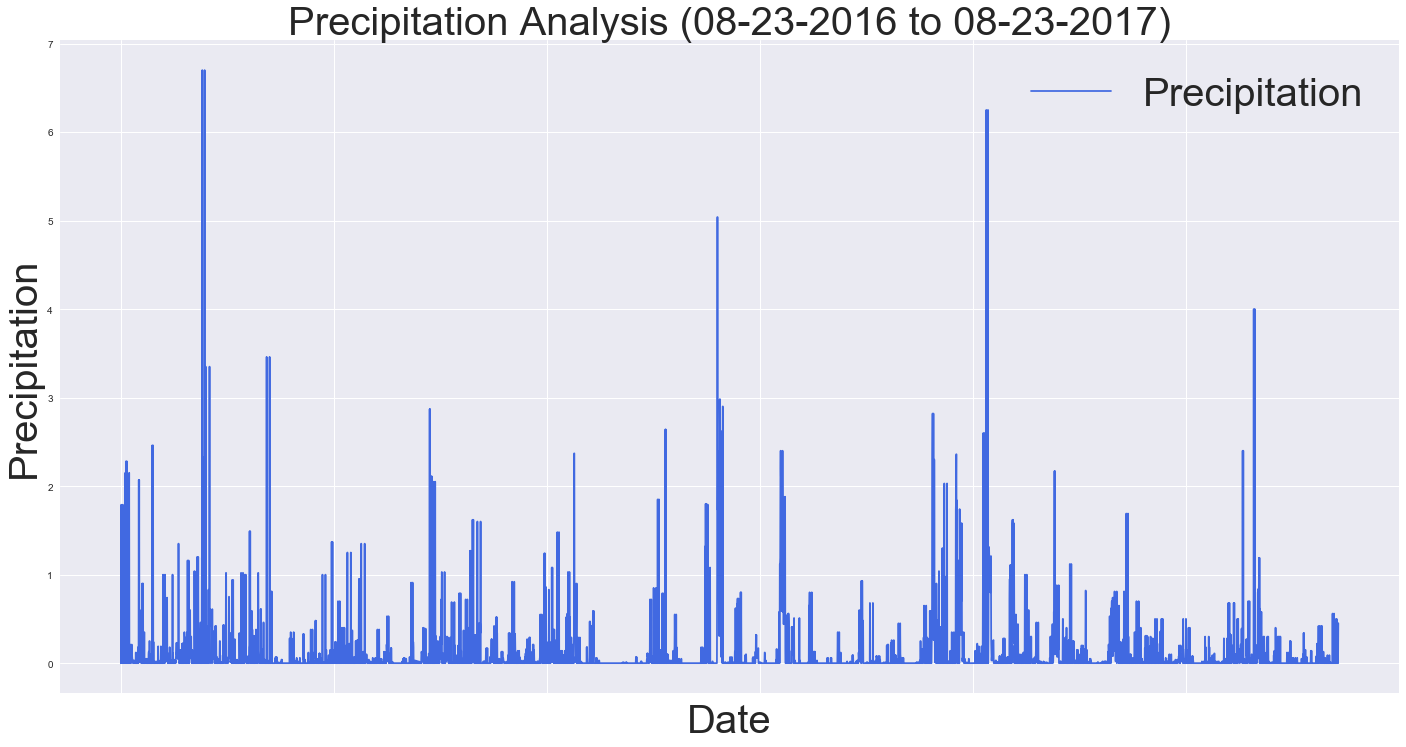

In [332]:
prcp_plot = prcp_df.plot(figsize = (24, 12), color='royalblue', sort_columns=True, use_index=True, grid=True)
plt.ylabel('Precipitation', fontsize = 40)
plt.xlabel('Date', fontsize = 40)
plt.legend(["Precipitation"], fontsize = 40)
plt.title("Precipitation Analysis (08-23-2016 to 08-23-2017)", fontsize = 40)
plt.xticks(rotation=45)
plt.show()

##### Print the summary statistics for the precipitation data

In [333]:
# Summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,5714.000000
mean,0.125404
std,0.396126
min,0.000000
25%,0.000000
50%,0.000000
75%,0.060000
max,6.700000


## Station Analysis

##### Design a query to calculate the total number of stations.

In [334]:
# Calculate the total number of stations
num_of_stations = session.query(Measurement.station).distinct(Measurement.station).count()
print("The total number of stations is "+ str(num_of_stations) + '.')

The total number of stations is 9.


##### Design a query to find the most active stations.

In [335]:
# List the stations and observation counts in descending order
# Find the highest number of observations
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"has",count, "weather observations.")

The busiest Station was USC00517948 with 6878 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00517948 has 6878 weather observations.
Station USC00514830 has 5994 weather observations.
Station USC00516128 has 5992 weather observations.
Station USC00519523 has 5920 weather observations.
Station USC00519397 has 5682 weather observations.
Station USC00519281 has 5544 weather observations.
Station USC00513117 has 5496 weather observations.
Station USC00511918 has 4240 weather observations.
Station USC00518838 has 2036 weather observations.


##### Design a query to retrieve the last 12 months of temperature observation data (tobs).

In [336]:
tobs_results = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date.between('2016-08-23', '2017-08-23')).all()

Most_active_stations_tobs_results = session.query(Measurement.station, Measurement.tobs).\
                                   filter(Measurement.date.between('2016-08-23', '2017-08-23')).\
                                   filter(Measurement.station == Most_active_stations).all()

In [337]:
Most_active_stations_temp = [result[1] for result in Most_active_stations_tobs_results[0:]]

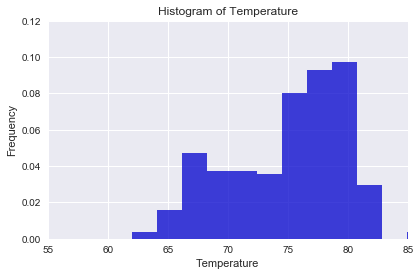

In [338]:
# plot the temperature data in a histogram with 12 bins
fig, ax = plt.subplots()
plt.hist(Most_active_stations_temp, color='mediumblue', bins = 12, align='mid', label="tobs", alpha=0.75, normed=1)
plt.xlabel('Temperature')
plt.ylabel("Frequency")
plt.title('Histogram of Temperature')
plt.axis([55, 85, 0, 0.12])
fig.tight_layout()
plt.show()

## Temperature Analysis

In [339]:
# Function calc_temp
def calc_temp(start_date, end_date):
    temp_data = session.query(func.max(Measurement.tobs),func.avg(Measurement.tobs),func.min(Measurement.tobs)).\
                       filter(Measurement.date >= start_date, Measurement.date <= end_date).one()
    return temp_data

In [340]:
temp_min, temp_max, temp_mean = calc_temp('2017-01-01', '2017-01-11')
temp_min, temp_max, temp_mean

(78, 68.26829268292683, 60)

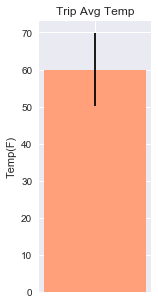

In [341]:
plt.figure(figsize=(2,5))
x = ['']
mean = [temp_mean]
variance = [temp_max - temp_min]
x_pos = x
plt.bar(x_pos, mean, color='lightsalmon', yerr=variance)
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")
plt.xticks(x_pos, x)
plt.savefig('temp_avg.png')
plt.show()